# Cross-Validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [2]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Forecasting-Time-Series-Data-with-Facebook-Prophet/main/data/online_retail.csv'

df = pd.read_csv(URL)
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

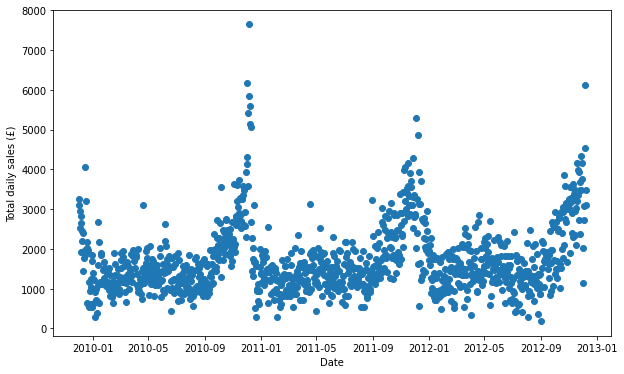

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'])
plt.xlabel('Date')
plt.ylabel('Total daily sales (£)')
plt.show()

## Performing forward-chaining cross-validation

**Forward-chaining cross-validation**, also called **rolling-origin cross-validation**, is similar 
to k-fold but suited to sequential data such as time series. There is no random shuffling of 
data to begin but a test set may be set aside. The test set must be the final portion of data, 
so if each fold is going to be 10% of your data (as it would be in 10-fold cross-validation), 
then your test set will be the final 10% of your date range.

In [4]:
model = Prophet(yearly_seasonality=4)
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       2379.45    0.00125648       164.644   1.248e-05       0.001      138  LS failed, Hessian reset 
      96       2379.58   0.000106219       63.7483   1.411e-06       0.001      197  LS failed, Hessian reset 
      99       2379.58   3.63198e-05       52.5391        0.96        0.96      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2379.59   1.46984e-05       81.2913   1.866e-07       0.001      296  LS failed, Hessian reset 
     164       2379.59   1.14861e-07       49.3578     0.08598           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


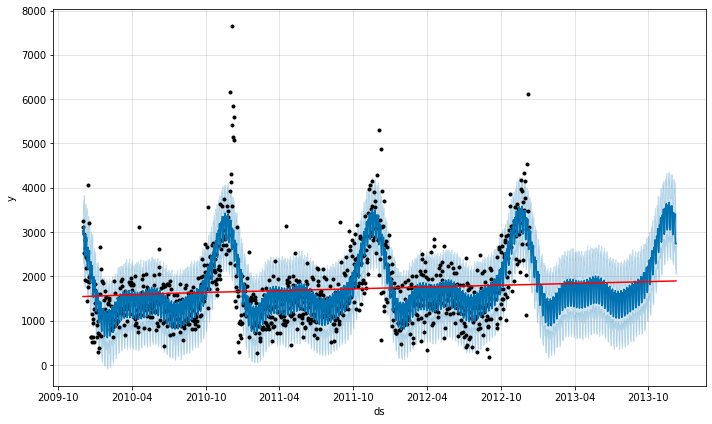

In [5]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

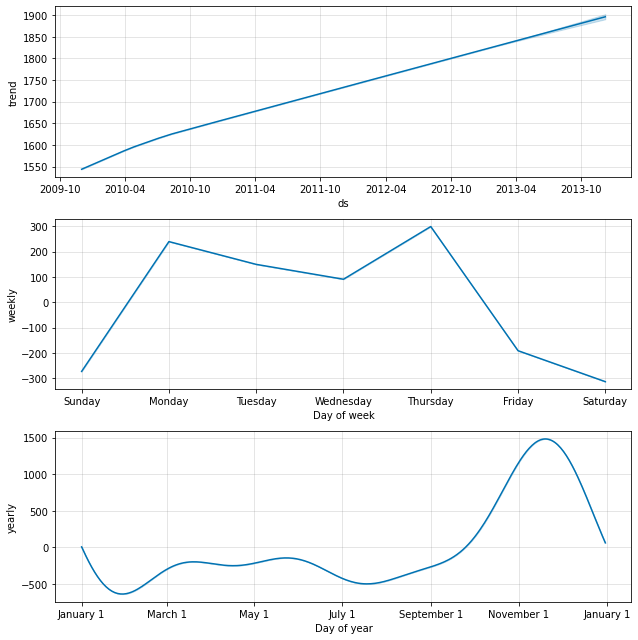

In [6]:
fig2 = model.plot_components(forecast)
plt.show()

In [8]:
from prophet.diagnostics import cross_validation

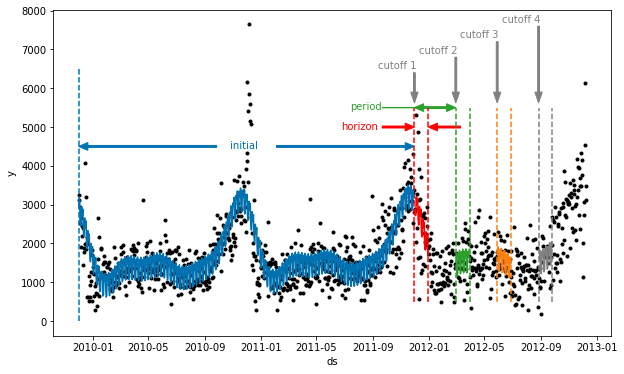

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], 'k.')
plt.vlines([df['ds'][730], df['ds'][760]], 500, 5500, colors='r', linestyles='--')
plt.vlines([df['ds'][820], df['ds'][850]], 500, 5500, colors='tab:green', linestyles='--')
plt.vlines([df['ds'][910], df['ds'][940]], 500, 5500, colors='tab:orange', linestyles='--')
plt.vlines([df['ds'][1000], df['ds'][1030]], 500, 5500, colors='gray', linestyles='--')
plt.vlines([df['ds'][0]], 0, 6500, colors='#0072B2', linestyles='--')

plt.plot(forecast[forecast['ds'] < df['ds'][730]]['ds'],
         forecast[forecast['ds'] < df['ds'][730]]['yhat'],
         c='#0072B2')

plt.plot(forecast[(forecast['ds'] < df['ds'][760]) &
                  (forecast['ds'] > df['ds'][730])]['ds'],
         forecast[(forecast['ds'] < df['ds'][760]) &
                  (forecast['ds'] > df['ds'][730])]['yhat'], c='r')

plt.plot(forecast[(forecast['ds'] < df['ds'][850]) &
                  (forecast['ds'] > df['ds'][820])]['ds'],
         forecast[(forecast['ds'] < df['ds'][850]) &
                  (forecast['ds'] > df['ds'][820])]['yhat'], c='tab:green')

plt.plot(forecast[(forecast['ds'] < df['ds'][940]) &
                  (forecast['ds'] > df['ds'][910])]['ds'],
         forecast[(forecast['ds'] < df['ds'][940]) &
                  (forecast['ds'] > df['ds'][910])]['yhat'], c='tab:orange')

plt.plot(forecast[(forecast['ds'] < df['ds'][1030]) &
                  (forecast['ds'] > df['ds'][1000])]['ds'],
         forecast[(forecast['ds'] < df['ds'][1030]) &
                  (forecast['ds'] > df['ds'][1000])]['yhat'], c='gray')

plt.arrow(df['ds'][660], 5000, 50, 0, width=50, head_width=200, head_length=20, color='r')
plt.arrow(df['ds'][830], 5000, -50, 0, width=50, head_width=200, head_length=20, color='r')
plt.text(df['ds'][570], 4950, 'horizon', color='r')

plt.arrow(df['ds'][660], 5500, 140, 0, width=10, head_width=200, head_length=20, color='tab:green')
plt.arrow(df['ds'][800], 5500, -50, 0, width=50, head_width=200, head_length=20, color='tab:green')
plt.text(df['ds'][590], 5450, 'period', color='tab:green')

plt.arrow(df['ds'][730], 6400, 0, -500, width=4, head_width=16, head_length=280, color='gray')
plt.text(df['ds'][650], 6500, 'cutoff 1', color='gray')

plt.arrow(df['ds'][820], 6800, 0, -900, width=4, head_width=16, head_length=280, color='gray')
plt.text(df['ds'][740], 6900, 'cutoff 2', color='gray')

plt.arrow(df['ds'][910], 7200, 0, -1300, width=4, head_width=16, head_length=280, color='gray')
plt.text(df['ds'][830], 7300, 'cutoff 3', color='gray')

plt.arrow(df['ds'][1000], 7600, 0, -1700, width=4, head_width=16, head_length=280, color='gray')
plt.text(df['ds'][920], 7700, 'cutoff 4', color='gray')

plt.arrow(df['ds'][300], 4500, -280, 0, width=50, head_width=200, head_length=20, color='#0072B2')
plt.arrow(df['ds'][430], 4500, 280, 0, width=50, head_width=200, head_length=20, color='#0072B2')
plt.text(df['ds'][330], 4450, 'initial', color='#0072B2')

plt.xlabel('ds')
plt.ylabel('y')

plt.show()

* `initial` is the first training period. For exemple, it would be the first five blocks 
of data in the first fold. It is the minimum amount of data needed to begin your 
training on.    

* `horizon` is the length of time you want to evaluate your forecast over. Let's say that 
this retail outlet is building their model so that they can predict sales over the next 
month. A horizon set to 30 days would make sense here, so that they are evaluating 
their model on the same parameter setting that they wish to use it on.  

* `period` is the amount of time between each fold. It can be either greater than the 
horizon or less than it, or even equal to it. 

* `cutoffs` are the dates where each horizon will begin.


For each `cutoff`, the model would be trained on all data up to that `cutoff`, and then 
a prediction will be made for the `horizon` period. That prediction will be compared to 
the known values and evaluated. Then, the model will be re-trained on all data up to the 
second `cutoff` and the process will be repeated. The final performance evaluation will be 
the average of the performance at each `cutoff`.

In [13]:
df_cv = cross_validation(
    model,
    horizon='90 days',
    period='30 days',
    initial='730 days'
)

INFO:prophet:Making 10 forecasts with cutoffs between 2011-12-14 00:00:00 and 2012-09-09 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1570.36   1.50036e-06       80.4064     0.03345           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1570.36   6.14819e-08         60.49      0.4813      0.4813      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1634.52   0.000230367       100.363      0.3429      0.3429      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       1636.06   0.000439937       96.8484   2.824e-06       0.001      216  LS failed, Hessian reset 
     171       1636.34    0.00035431       91.1997   4.476e-06       0.0

We begin our training with an `initial` period of 2 years, which is `'730 days'`. We set 
`horizon='90 days'` to evaluate our forecast over a 90-day prediction interval. And 
finally, we set `period='30 days'`, so we re-train and re-evaluate our model every 30 
days. This results in a total of 10 forecasts to compare with the final year of data.

In [11]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-12-15,2801.361915,2017.495398,3498.622145,3702.986147,2011-12-14
1,2011-12-16,2352.472912,1662.705857,3097.199148,1229.263629,2011-12-14
2,2011-12-17,2182.525172,1472.649873,2874.018388,1325.415023,2011-12-14
3,2011-12-18,2165.613157,1409.119841,2847.187173,2739.454215,2011-12-14
4,2011-12-19,2636.302965,1917.022629,3330.928917,2699.823386,2011-12-14


## Parallelizing cross-validation

Setting `parallel='processes'` uses Python's `concurrent.futures.`
`ProcessPoolExecutor` class, whereas `parallel='threads'` uses `concurrent.`
`futures.ThreadPoolExecutor`. If you're unsure which of these to use, go with 
`'processes'`. It will give the best performance on a single machine.

In [14]:
df_cv = cross_validation(
    model,
    horizon='90 days',
    period='30 days',
    initial='730 days',
    parallel='processes'
)

INFO:prophet:Making 10 forecasts with cutoffs between 2011-12-14 00:00:00 and 2012-09-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd30df3f7c0>


Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.7545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1570.36   1.50036e-06       80.4064     0.03345           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.0803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1570.36   6.14819e-08         60.49      0.4813      0.4813      189   
Optimization terminated normally: 
  Convergence detected: relative g

In [15]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-12-15,2801.361915,2074.736599,3470.299460,3702.986147,2011-12-14
1,2011-12-16,2352.472912,1610.919765,3098.973786,1229.263629,2011-12-14
2,2011-12-17,2182.525172,1507.662362,2930.164830,1325.415023,2011-12-14
3,2011-12-18,2165.613157,1484.871476,2858.607769,2739.454215,2011-12-14
4,2011-12-19,2636.302965,1943.696196,3376.956452,2699.823386,2011-12-14


In [17]:
from dask.distributed import Client

client = Client()
df_cv = cross_validation(
    model,
    horizon='90 days',
    period='30 days',
    initial='730 days',
    parallel='dask'
)

/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44613 instead
  warnings.warn(
INFO:prophet:Making 10 forecasts with cutoffs between 2011-12-14 00:00:00 and 2012-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38491' processes=6 threads=24, memory=110.05 GiB>


Initial log joint probability = -12.0658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1782.46    0.00213005       107.336           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1783.89   7.42037e-07       60.8258      0.9045      0.9045      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1783.89   3.97905e-08       65.5009      0.1939      0.1939      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1634.52   0.000230367       100.363      0.3429      0.3429      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

> Although you can use Dask on your laptop, its power really comes into effect when using 
> multiple computing clusters across many machines. If you don't have access to this type of 
> computing power, `parallel='processes'` will usually be the faster option.